In [ ]:
from IPython.display import display, HTML 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h1 style="color:red;">DI-725 : Transformers and Attention-Based Deep Networks</h1>
  <h2 style="color:red;">Final Project : Phase - 2</h2>
  <br><br>
  <h4 style="color:red;">Turgay Yıldız</h4>
  <br>
  <h4 style="color:red;">Graduate School of Informatics, Middle East Technical University (METU)</h4>
</div>

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Fetch big_vision code and install dependencies</h3>
</div>

In [1]:
import os
import sys
import kagglehub
from google.colab import userdata

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import (
    AutoProcessor,
    AutoModel,
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
)

import matplotlib.pyplot as plt 

2025-05-05 17:44:02.986813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746467043.011358     357 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746467043.018743     357 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
;# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [3]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [5]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model and Pre-trained weights : </h3>
</div>

In [6]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["..."] =    '...'
os.environ["..."]      =    '...'

In [7]:
from huggingface_hub import ...

# replace "hf_XXX" with your actual token (keep it secret!)
...(...="...")

In [8]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [9]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !wget https://storage.googleapis.com/big_vision/paligemma_tokenizer.model -O {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}") 

In [ ]:
#!pip install bitsandbytes

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> SIGLIP</h3>
</div>

In [10]:
siglip = AutoModel.from_pretrained(
                                  "google/siglip2-base-patch16-224",
                                  #quantization_config = bnb_config,
                                  torch_dtype         = torch.float16,
                                  device_map          = "cpu",
                                  attn_implementation = "sdpa",
                              ).eval() 

In [11]:
processor = AutoProcessor.from_pretrained("google/siglip2-base-patch16-224",  use_fast=True)  

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Freeze : </h3>
</div>

In [12]:
def freeze(model): 
    
    def freeze_with_mask(model, is_trainable_param):
        trainable_mask = {}
        for name, param in model.named_parameters():
            trainable = is_trainable_param(name, param)
            param.requires_grad = trainable
            trainable_mask[name] = trainable
            # Optional debug:
            # print(f"{name}: {'TRAIN' if trainable else 'FREEZE'}")
        return trainable_mask
    
    
    # your predicate:
    def is_trainable_param(name, param):
        if name.startswith("gemma.model.decoder.layers") and "attn" in name:
            return True
        if name.startswith("proj"):
            return True
        # freeze everything else
        return False

    return freeze_with_mask(model, is_trainable_param) 

In [13]:
m1  =  freeze(siglip) 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Number of Parameters: </h3>
</div>

In [14]:
def num_params(model):
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}") 

In [ ]:
num_params(siglip)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Siglip outputs : </h3>
</div>

In [15]:
if torch.cuda.is_available:

    dev_name  =  "cuda"

else: dev_name = "cpu"


device  =  torch.device(dev_name) 

In [16]:
print(device) 

cuda


In [ ]:
from transformers.image_utils import load_image

image    =   load_image("https://huggingface.co/datasets/merve/coco/resolve/main/val2017/000000000285.jpg")
inputs   =   processor(images=[image], return_tensors="pt")

In [ ]:
inputs

In [ ]:

# run infernece
with torch.no_grad():
    
    outputs = siglip.vision_model(pixel_values=inputs["pixel_values"])


last_hidden_state = outputs.last_hidden_state

print(last_hidden_state.shape)
 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> GEMMA : </h3>
</div>

In [17]:

gemma = AutoModelForCausalLM.from_pretrained(
                                            "google/gemma-2b",
                                            #quantization_config           = bnb_config,
                                            torch_dtype                   = torch.float16,
                                            device_map                    = "cpu", 
                                        ).eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
m2   =   freeze(gemma) 

In [21]:
num_params(gemma)

Total params: 2,506,172,416
Trainable params: 0


In [19]:
#tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b") 

import sentencepiece as spm

tokenizer = spm.SentencePieceProcessor()
tokenizer.load(TOKENIZER_PATH)  # TOKENIZER_PATH should be a .model file


True

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> GEMMA's outputs : </h3>
</div>

In [ ]:
text   = " en : Define the image?"

ids    = tokenizer.encode(text)                # Returns a list of token ids
tokens = tokenizer.encode(text, out_type=str)  # Returns list of tokens 


In [ ]:
ids

In [ ]:
tokens

In [ ]:
# Get token embeddings: shape [1, seq_len, 2048]

text_embeds = gemma.model.embed_tokens(torch.tensor(ids).to(device))

print(text_embeds.shape)  

In [ ]:
text_embeds

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Projection after Siglip : </h3>
</div>

In [ ]:
proj = nn.Linear(768, 2048).half().to(device) 

In [ ]:
projected_image_embeds  =  proj(last_hidden_state) 

In [ ]:
projected_image_embeds.shape

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Concate Proj + Prompt : </h3>
</div>

In [ ]:
combined_embeds = torch.cat([projected_image_embeds, text_embeds], dim=1)  # [1, 197 + seq_len, 2048]


In [ ]:
print(combined_embeds.shape)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Then, Put them into the GEMMA : </h3>
</div>

In [ ]:
# Create a matching attention mask
image_attention_mask    = torch.ones(projected_image_embeds.shape[:-1], dtype=torch.long).to(device)
combined_attention_mask = torch.cat([image_attention_mask, tokens["attention_mask"]], dim=1)

# Forward pass (important: use inputs_embeds instead of input_ids)
outputs = gemma(
    inputs_embeds=combined_embeds,
    attention_mask=combined_attention_mask,
)

# You can generate by continuing this input (if needed)
logits = outputs.logits


In [ ]:
outputs

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Combine all parts into one : </h3>
</div> 

In [ ]:
import torch
import torch.nn as nn

class CombinedModel(nn.Module):
    def __init__(self, siglip, gemma, tokenizer, proj_dim=2048):
        super().__init__()
        
        self.siglip      =   siglip.vision_model   # expects pixel_values [B,3,H,W]
        self.proj        =   nn.Linear(768, proj_dim, bias=False).half()
        self.gemma       =   gemma
        self.tokenizer   =   tokenizer

    def forward(self, images, input_ids, attention_mask):
        """
        images:         torch.FloatTensor of shape [B, 3, H, W]
        input_ids:      torch.LongTensor  of shape [B, seq_len]
        attention_mask: torch.LongTensor  of shape [B, seq_len]
        """

        # 1) Image → SigLIP patch embeddings
        vision_out = self.siglip(pixel_values=images)         # [B, 197, 768]
        img_tokens = vision_out.last_hidden_state.half()      # ensure same dtype as proj

        # 2) Project to Gemma's hidden size
        proj_img = self.proj(img_tokens)                      # [B, 197, 2048]

        # 3) Embed text tokens
        txt_embeds = self.gemma.get_input_embeddings()(input_ids)  # [B, seq_len, 2048]

        # 4) Concatenate and build attention mask
        combined        =    torch.cat([proj_img, txt_embeds], dim=1)       # [B, 197+seq_len, 2048]
        bsz, n_img, _   =    proj_img.size()
        img_mask        =    torch.ones(bsz, n_img, device=images.device, dtype=torch.long)
        attn_mask       =    torch.cat([img_mask, attention_mask], dim=1)  # [B, 197+seq_len] 

        generated_ids   =    self.gemma.generate(
                                                inputs_embeds   =  combined,
                                                attention_mask  =  attn_mask,
                                                max_new_tokens  =  64, 
                                                num_beams       =  1,
                                                do_sample       =  False,
                                                eos_token_id    =  self.tokenizer.eos_token_id  
                                            )
        
        captions = [self.tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
        
        return  captions


In [ ]:
model   =  CombinedModel(siglip, gemma, tokenizer, proj_dim=2048).to(device)   

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sanity Check on only text : </h3>
</div> 

In [ ]:
text   = "Write a short story about giants."

ids    = tokenizer.encode(text)  

input_ids = torch.tensor(ids).unsqueeze(0)  # [1, seq_len]

# Manually create attention mask (1 for real tokens, 0 for padding)
attention_mask = torch.ones_like(input_ids) 

In [ ]:
input_ids          =   input_ids.to("cpu")
attention_mask     =   attention_mask.to("cpu")    

In [ ]:
txt_embeds = gemma.get_input_embeddings()(input_ids)  

In [ ]:
txt_embeds

In [ ]:
eos_token_id = tokenizer.piece_to_id('<eos>') 
pad_token_id = tokenizer.piece_to_id('<pad>')  

In [ ]:
generated_ids   = gemma.generate(
                                                inputs_embeds   =  txt_embeds,
                                                attention_mask  =  attention_mask,
                                                max_new_tokens  =  64, 
                                                num_beams       =  1,
                                                do_sample       =  False,
                                                eos_token_id    =  eos_token_id  
                                            )

In [ ]:
captions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids] 

In [ ]:
captions

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sanity Check for visual-tokens from SigLip + text-tokens into gemma: </h3>
</div> 

In [ ]:
text   = "What does the bear in the image do?"

tokens = tokenizer(text, return_tensors="pt") 

In [ ]:
plt.imshow(inputs["pixel_values"].cpu().view(224, 224, 3))

In [ ]:
tokens["input_ids"]       =   tokens["input_ids"].to(device)
tokens["attention_mask"]  =   tokens["attention_mask"].to(device)   
inputs["pixel_values"]    =   inputs["pixel_values"].to(device)

In [ ]:
out  =  model(inputs["pixel_values"], tokens["input_ids"], tokens["attention_mask"]) 

In [ ]:
out

### It is understandable getting gibberish . 
### Because we concatenated some visual tokens which are continuous and do not correspond to any real word. 
### Therefore, gemma can not interpret them. So, we need to fine-tune the model like PaliGemma, or train. 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model for training: </h3>
</div> 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, siglip, gemma, tokenizer, proj_dim=2048):
        super().__init__()
        self.siglip    = siglip.vision_model
        self.proj      = nn.Linear(768, proj_dim, bias=False).half()
        self.gemma     = gemma
        self.tokenizer = tokenizer
        
        self.eos_token_id = tokenizer.piece_to_id('<eos>') 
        self.pad_token_id = tokenizer.piece_to_id('<pad>')   

    def _build_combined(self, proj_img, txt_embeds, attention_mask):
        bsz, n_img, _ = proj_img.size()
        img_mask      = torch.ones(bsz, n_img,
                                   device=proj_img.device,
                                   dtype=torch.long)
        attn_mask     = torch.cat([img_mask, attention_mask], dim=1)
        combined      = torch.cat([proj_img, txt_embeds], dim=1)
        
        return combined, attn_mask

    def forward(self,
                images: torch.FloatTensor,
                input_ids: torch.LongTensor,
                attention_mask: torch.LongTensor):
        
        # 1) Image → SigLIP patch embeddings
        vision_out = self.siglip(pixel_values=images)
        img_tokens = vision_out.last_hidden_state.half()          # [B,197,768]

        # 2) Project to Gemma’s hidden size
        proj_img   = self.proj(img_tokens)                       # [B,197,2048]

        # 3) Embed text tokens
        txt_embeds = self.gemma.get_input_embeddings()(input_ids) # [B,seq_len,2048]

        # 4) Concat and build attention mask
        combined, attn_mask = self._build_combined(proj_img, txt_embeds, attention_mask)

        # 5) Forward through LM head WITHOUT labels
        outputs = self.gemma(
            inputs_embeds  = combined,
            attention_mask = attn_mask,
            return_dict    = True
        )
        logits = outputs.logits                                   # [B,197+seq_len, V]

        # 6) Slice out only the text portion and compute CE loss
        B, total_len, V = logits.size()
        seq_len         = input_ids.size(1)
        L_in            = seq_len - 1                             # predict next token
        N               = total_len - L_in                        # offset = 197
        text_logits     = logits[:, N : N + L_in, :].reshape(-1, V)
        targets         = input_ids[:, 1:].reshape(-1)

        pad_id          = self.pad_token_id
        loss            = F.cross_entropy(text_logits,
                                         targets,
                                         ignore_index=pad_id)



        return loss
 

In [23]:
model   =   CombinedModel(siglip, gemma, tokenizer).to(device)  

In [ ]:
out  =  model(inputs["pixel_values"], tokens["input_ids"], tokens["attention_mask"])  

In [ ]:
out

In [ ]:
m3    =   freeze(model) 

In [ ]:
num_params(model)  

In [ ]:
#params = model.parameters() 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Core Library Imports : </h3>
</div> 

In [24]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Reserve GPU/TPU for JAX </h3>
</div>

In [25]:
# Don't let TF use the GPU or TPUs
# Disables TensorFlow’s access to GPUs/TPUs so JAX can fully utilize them without resource contention.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Construct model and load params into RAM </h3>

 <h5 style="color:red;"> model_config: hyperparameters for both the vision encoder and text decoder.
<br>
                          Instantiate the combined Vision+LLM model.
<br>
                          Load pretrained weights into a parameter tree.
<br>
                          Build a decode function for efficient batched generation.
                          </h5>


</div>

In [26]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()) 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sharding & Casting Parameters :  </h3>

  <h5 style="color:red;">  Sharding: split tensors across devices (if you had >1 GPU).
<br>
                        maybe_cast_to_f32: keep the frozen weights in fp16 to save memory; cast the few trainable ones to fp32 so their gradients remain stable.
<br>
                        The loop unpacks the parameter tree, reshares & casts each leaf, and reassembles it.
</h5>
</div>


In [27]:
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

In [28]:
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

In [ ]:
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

In [ ]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [ ]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [ ]:
def to_numpy_safe(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x


In [ ]:
params_flat, treedef       = jax.tree.flatten(params)
sharding_leaves            = jax.tree.leaves(params_sharding)
trainable_leaves           = jax.tree.leaves(trainable_mask)

new_params_flat = []

for idx, (param, sharding, trainable) in enumerate(zip(params_flat, sharding_leaves, trainable_leaves)):
    param = to_numpy_safe(param)
    param = big_vision.utils.reshard(param, sharding)
    param = maybe_cast_to_f32(param, trainable)
    param.block_until_ready()
    new_params_flat.append(param)

params = jax.tree.unflatten(treedef, new_params_flat)


In [ ]:
# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


In [ ]:
print(" == Model params == ")
parameter_overview(params)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define preprocess functions to create inputs to the model :  </h3>
</div>

In [29]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Import Data  :  </h3>
</div>

In [30]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np

In [31]:
captions_df = pd.read_csv('/kaggle/input/rsics-dataset/captions.csv')
print(captions_df.head())  

  source split           image  \
0   NWPU  test  NWPU_31430.jpg   
1   NWPU  test  NWPU_31431.jpg   
2   NWPU  test  NWPU_31432.jpg   
3   NWPU  test  NWPU_31433.jpg   
4   NWPU  test  NWPU_31434.jpg   

                                           caption_1  \
0   A gray plane on the runway and the lawn beside .   
1  Three small planes parked in a line on the air...   
2  A plane parked in a line on the airport with s...   
3  A small plane and a big plane parked next to b...   
4       Two planes parked next to boarding bridges .   

                                           caption_2  \
0        A grey plane is on the runway by the lawn .   
1  There are four aircraft on the open ground, Th...   
2  A white plane was parked on the instruction li...   
3  A white plane and a gray plane parked at the b...   
4  Two aircraft were parked at the departure gates .   

                                           caption_3  \
0  There is an airplane on the runway with a larg...   
1  There 

In [32]:

IMAGE_ROOT = "/kaggle/input/rsics-dataset/resized" 
BATCH_SIZE = 32
IMG_SIZE   = (224, 224)  

In [33]:
print("All split labels:", captions_df['split'].unique())
print("Counts:\n", captions_df['split'].value_counts()) 

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [34]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = captions_df[captions_df['split'] == split_name] 

In [35]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions

In [36]:
train_paths, train_caps = df_to_paths_and_captions(splits['train'])
val_paths,   val_caps   = df_to_paths_and_captions(splits['val'])
test_paths,  test_caps  = df_to_paths_and_captions(splits['test'])

In [37]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
         )
    return ds

In [38]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=True)
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False)

In [39]:
# 8. Quick sanity check
for imgs, caps in test_ds.take(1):
    print("Images batch shape:", imgs.shape)            # (BATCH_SIZE, H, W, 3)
    print("Captions batch shape:", len(caps), "examples")
    print("First example captions:", caps[0])            # a list of 5 strings

Images batch shape: (32, 224, 224, 3)
Captions batch shape: 32 examples
First example captions: tf.Tensor(
[b'A gray plane on the runway and the lawn beside .'
 b'A grey plane is on the runway by the lawn .'
 b'There is an airplane on the runway with a large lawn by the runway .'
 b'A plane is parked on the runway next to the grass .'
 b'There is a plane on the runway beside the grass .'], shape=(5,), dtype=string)


In [40]:
def train_data_iterator():
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                # Decode all 5 captions into Python strings
                decoded_caps = [c.decode('utf-8') for c in caps]

                # Prepare the model input from a random caption
                suffix = decoded_caps[np.random.randint(5)].lower()
                prefix = "caption en"

                tokens, mask_ar, mask_loss, _ = preprocess_tokens(
                    prefix, suffix, SEQLEN
                )

                img_proc = img * 2.0 - 1.0
                yield [{
                    "image":     img_proc,
                    "text":      np.asarray(tokens,    dtype=np.int32),
                    "mask_ar":   np.asarray(mask_ar,    dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss,  dtype=np.int32),
                },
                    decoded_caps,
                      ]

#----------------------------------------------------------------------------------------------------------------#
#                                              Validation :
#----------------------------------------------------------------------------------------------------------------#
def validation_data_iterator():
    """Single-pass iterator over validation examples from val_ds."""
    for image_batch, caps_batch in val_ds:

         images_np = image_batch.numpy()
         caps_np   = caps_batch.numpy()

         for img, caps in zip(images_np, caps_np):

            decoded_caps =   [c.decode('utf-8') for c in caps]
            suffix       =   decoded_caps[np.random.randint(5)].lower()
            prefix       =   "caption en"

            tokens, mask_ar, _, mask_input = preprocess_tokens(
                 prefix,  seqlen=SEQLEN)

            img_proc = img * 2. - 1.
            yield [{
                 "image":     img_proc,
                 "text":      np.asarray(tokens,     dtype=np.int32),
                 "mask_input": np.asarray(mask_input, dtype=np.int32),
                 "mask_ar":    np.asarray(mask_ar,    dtype=np.int32),
            },
                 decoded_caps,
                  ]


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Check Iterators :  </h3>
</div>

In [41]:
SEQLEN   =   128

In [ ]:
val_it = validation_data_iterator()

for _ in range(1):
    ex   = next(val_it)

In [ ]:
ex[0]["image"].shape,   ex[0]["text"].shape,  ex[0]["mask_input"].shape,   ex[0]["mask_ar"].shape

In [ ]:
ex[1]

~~~python```
    def forward(self,
                image: torch.FloatTensor,        # [3, H, W]
                input_ids: torch.LongTensor,     # [seq_len]
                attention_mask: torch.LongTensor # [seq_len]
               ):
        # --- 1) Image → SigLIP patches ---
        # add batch dim
        pixels = image.unsqueeze(0)                     # [1,3,H,W]
        vision_out = self.siglip(pixel_values=pixels)   # HF API: pixel_values
        img_tokens = vision_out.last_hidden_state.half()# [1,197,768]

        # --- 2) Project to Gemma’s hidden size ---
        proj_img = self.proj(img_tokens)                # [1,197,2048]

        # --- 3) Embed text tokens ---
        # add batch dim
        ids  = input_ids.unsqueeze(0)                   # [1, seq_len]
        mask = attention_mask.unsqueeze(0)              # [1, seq_len]
        txt_embeds = self.gemma.get_input_embeddings()(ids)  # [1,seq_len,2048]

        # --- 4) Concat and build attention mask ---
        combined = torch.cat([proj_img, txt_embeds], dim=1)  
        img_mask = torch.ones(proj_img.size()[:2], dtype=torch.long, device=combined.device)
        attn_mask = torch.cat([img_mask, mask], dim=1)  

        # --- 5) Forward into Gemma as continuous embeddings ---
        return self.gemma(inputs_embeds=combined, attention_mask=attn_mask)
        ```

In [ ]:
model(torch.tensor(ex[0]["image"].reshape(1,3,224,224)).to(device), torch.tensor(ex[0]["text"].reshape(1,128)).long().to(device), torch.tensor(ex[0]["mask_input"].reshape(1,128)).long().to(device)) 

In [ ]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


In [42]:
import html

In [ ]:
html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    img = example[0]["image"]

    html_out += render_example(img, example[1][0])
    # optionally a divider between images:
    html_out += "<hr style='width:100%;'>"

display(HTML("<h3>Training examples </h3>" + html_out))


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define the training step and evaluation loop :  </h3>
</div>

In [43]:
!pip install evaluate
!pip install rouge_score
print("ok")

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ok


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> WANDB :  </h3>
</div>

In [44]:
import wandb

In [104]:
wandb.finish() 

eval/bleu,▁
eval/meteor,▁
eval/rouge1,▁
eval/rouge2,▁
eval/rougeL,▁
eval/bleu,0.00019
eval/meteor,0.00238
eval/rouge1,0.00072
eval/rouge2,0
eval/rougeL,0.00072
train/loss,nan


In [105]:
os.environ["..."]       = "...."

run  =  wandb.init(project="...", entity="..." ) 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Train :  </h3>
</div>

In [47]:
def make_predictions(model, batch, num_examples=1, batch_size=1, max_length=64, **gen_kwargs):
    """
    batch: list of (example, reference) tuples.
    Returns a list of (image_id, predicted_string) pairs.
    """
    model.eval()
    hyps = []
    # we assume each example tuple has .text input ids/mask prepared
    for (example, ref) in batch:
        # pack inputs
        input_ids       = torch.from_numpy(example["text"]).unsqueeze(0).to(device)     # [1, seq]
        attention_mask  = torch.from_numpy(example["mask_input"]).unsqueeze(0).to(device)
        with torch.no_grad():
            # adjust generation kwargs to your model (e.g. num_beams, do_sample, etc.)
            out = model.gemma.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=60, 
                **gen_kwargs
            )
        # decode (you may need your tokenizer.decode here)
        hyp = tokenizer.decode(out[0].tolist())

        hyps.append(hyp) 
    return hyps

In [ ]:
#------------------------------------------------------------------------------------------------#
# DataLoader wrapper
class TorchDataset(torch.utils.data.IterableDataset):
    def __iter__(self):
        for example, _ in train_data_iterator():
            yield example
#------------------------------------------------------------------------------------------------#
train_loader = DataLoader(TorchDataset(), batch_size=1)
#------------------------------------------------------------------------------------------------#

In [ ]:
from torch.optim import AdamW

opt = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [ ]:
# Helper to convert numpy or tensor to torch.Tensor
def to_torch(x, dtype=None, device=None):
    if isinstance(x, torch.Tensor):
        t = x
    else:
        t = torch.from_numpy(x)
    if dtype is not None:
        t = t.to(dtype)
    if device is not None:
        t = t.to(device)
    return t


In [ ]:
step = 0
for batch in train_loader:
    
    if step >= 100:
        break
        
    model.train()
    opt.zero_grad()
   
    # Move to device
    imgs = to_torch(batch["image"].view(1, 3, 224, 224), dtype=torch.float32, device=device)   # [B,3,H,W]
    ids  = to_torch(batch["text"],  dtype=torch.long,  device=device)     # [B, seq_len]
    mask = to_torch(batch["mask_ar"],dtype=torch.long,  device=device)    # [B, seq_len]

    # Forward (drop last token for inputs)
    outputs = model(imgs, ids[:, :-1], mask[:, :-1])
    loss    = outputs
#------------------------------------------------------------------------------------------------#
    loss.backward()
    opt.step()
    break 

In [ ]:
loss

In [91]:
N = 8
demo_samples = []
for (example, caps), hyp in zip(validation_data_iterator(), all_hyps):
    if len(demo_samples) >= N:
        break
    img = example["image"]  # float array in [-1, 1]

    demo_samples.append((img, hyp, caps)) 



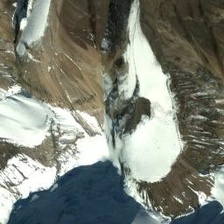
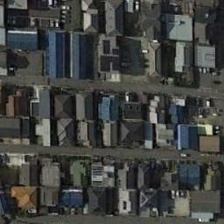
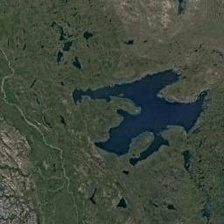
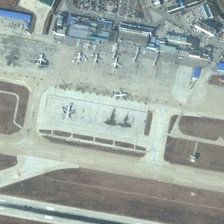
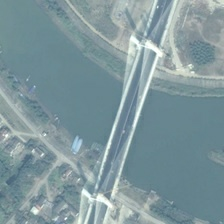
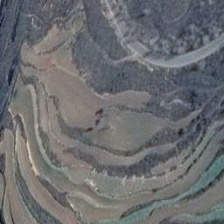
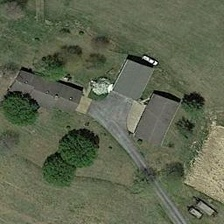
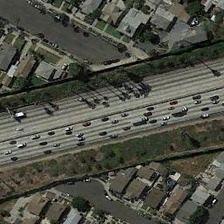

In [96]:
N = 8
demo_samples = []
for (example, caps), hyp in zip(validation_data_iterator(), all_hyps):
    if len(demo_samples) >= N:
        break
    img = example["image"]  # float array in [-1, 1]

    demo_samples.append((img, hyp, caps)) 


# 2) Display inline HTML gallery

imgs    =    [demo_samples[i][0]       for i in range(8)]
preds   =    [demo_samples[i][1]       for i in range(8)]
refs    =    [demo_samples[i][2]       for i in range(8)] 


html = ["<div style='display:flex; gap:16px;'>"]
for img, pred, ref in zip(imgs, preds, refs):

    if img.shape[0] == 3:  # Assuming CHW format
        img = img.transpose(1, 2, 0)
    
    img_uint8 = ((img + 1) * 127.5).clip(0, 255).astype("uint8")
    buf = io.BytesIO()
    Image.fromarray(img_uint8).save(buf, "PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()
    html.append(f"""
      <div style='text-align:center;'>
        <img src="data:image/png;base64,{b64}" width=200 /><br/>
        <strong>Pred:</strong> {pred}<br/>
        <strong>Ref:</strong> {ref}
      </div>""")
html.append("</div>")
display(HTML("".join(html)))


In [ ]:
#del imgs
#del ids
#del mask

del batch

In [106]:
torch.cuda.empty_cache()

In [107]:
!nvidia-smi

Mon May  5 18:34:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             33W /  250W |    5471MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  0%|          | 0/10 [00:00<?, ?it/s]

   BLEU:   0.00
   ROUGE1: 0.00, ROUGE2: 0.00, ROUGEL: 0.00
   METEOR: 0.00



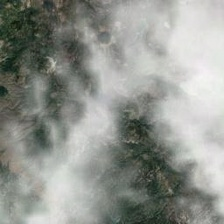
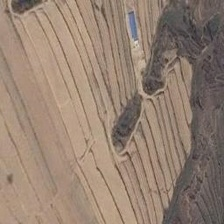
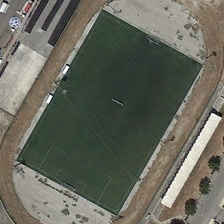
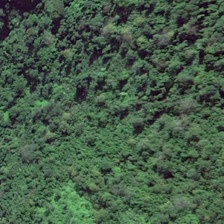
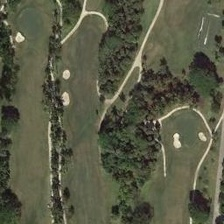
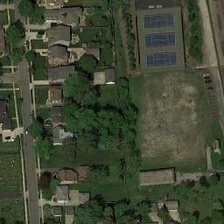
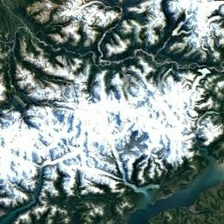
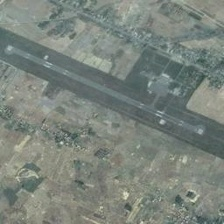

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import numpy as np
import evaluate
import wandb
from PIL import Image
from IPython.display import HTML, display
import io, base64
import tqdm
#------------------------------------------------------------------------------------------------#
# ──────────────── SETUP ──────────────── #

# Metrics
bleu_metric   = evaluate.load("bleu")
rouge_metric  = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
#------------------------------------------------------------------------------------------------#
# Hyperparams
BATCH_SIZE     = 8
TRAIN_EXAMPLES = 35614
LEARNING_RATE  = 1e-4
TRAIN_STEPS    = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_EVERY     = 8  
num_epochs     = 10
#------------------------------------------------------------------------------------------------#
run.config.update({
    "model_name"     : "Siglip + Projection + Gemma",
    "batch_size":     BATCH_SIZE,
    "train_examples": TRAIN_EXAMPLES,
    "learning_rate":  LEARNING_RATE,
    "train_steps":    TRAIN_STEPS,
})
#------------------------------------------------------------------------------------------------#
opt = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
#------------------------------------------------------------------------------------------------#
# DataLoader wrapper
class TorchDataset(torch.utils.data.IterableDataset):
    def __iter__(self):
        for example, _ in train_data_iterator():
            yield example
#------------------------------------------------------------------------------------------------#
train_loader = DataLoader(TorchDataset(), batch_size=BATCH_SIZE)
#------------------------------------------------------------------------------------------------#
# Helper to convert numpy or tensor to torch.Tensor
def to_torch(x, dtype=None, device=None):
    if isinstance(x, torch.Tensor):
        t = x
    else:
        t = torch.from_numpy(x)
    if dtype is not None:
        t = t.to(dtype)
    if device is not None:
        t = t.to(device)
    return t

#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
# ──────────────── TRAIN + EVAL LOOP ──────────────── #
step = 0

for epoch in tqdm.tqdm(range(num_epochs)): 
    
    for batch in train_loader: 
        
        model.train()
        opt.zero_grad()
       
        # Move to device
        imgs = to_torch(batch["image"].view(BATCH_SIZE, 3, 224, 224), dtype=torch.float32, device=device)   # [B,3,H,W]
        ids  = to_torch(batch["text"],  dtype=torch.long,  device=device)     # [B, seq_len]
        mask = to_torch(batch["mask_ar"],dtype=torch.long,  device=device)    # [B, seq_len]
    
        # Forward (drop last token for inputs)
        outputs = model(imgs, ids[:, :-1], mask[:, :-1])
        loss    = outputs
    #------------------------------------------------------------------------------------------------#
        loss.backward()
        opt.step()
    
        # Log training loss
        step += 1
    #------------------------------------------------------------------------------------------------#   
        wandb.log({"train/loss": loss.item()}, step=step)
    #------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------#
        torch.cuda.empty_cache()
        
        # ───── EVALUATION ───── #
        if step == 1 or step % EVAL_EVERY == 0:
            model.eval()
            all_hyps, all_refs = [], []
        
            for (example, caps), _ in zip(validation_data_iterator(), range(8)):
                # Ensure example is preprocessed with .text and .mask_input
                with torch.no_grad():
                    pred = make_predictions(
                        model,
                        [(example, caps)],   # this is already the correct format for `batch`
                        num_examples=1,
                        batch_size=1,
                        max_length=128
                    )[0]  # single prediction string
        
                all_hyps.append(pred)
                all_refs.append([caps])  # wrap in list for BLEU/METEOR etc.
    
            # compute metrics
            bleu_res   = bleu_metric.compute(predictions=all_hyps, references=all_refs, smooth=True)
            rouge_res  = rouge_metric.compute(predictions=all_hyps, references=all_refs)
            meteor_res = meteor_metric.compute(predictions=all_hyps, references=all_refs)
    
            print(f"   BLEU:   {bleu_res['bleu']:.2f}")
            print(f"   ROUGE1: {rouge_res['rouge1']:.2f}, ROUGE2: {rouge_res['rouge2']:.2f}, ROUGEL: {rouge_res['rougeL']:.2f}")
            print(f"   METEOR: {meteor_res['meteor']:.2f}")
    
            wandb.log({
                "eval/bleu":    bleu_res["bleu"],
                "eval/rouge1":  rouge_res["rouge1"],
                "eval/rouge2":  rouge_res["rouge2"],
                "eval/rougeL":  rouge_res["rougeL"],
                "eval/meteor":  meteor_res["meteor"],
            }, step=step)
    #---------------------------------------------------------------------------------------------------------------------------#
    #                   ---- Demo‐sample pass via make_predictions ----
    #---------------------------------------------------------------------------------------------------------------------------#
            # (inside your eval block, after computing all_hyps & all_refs)
            
            # 1) Collect N demo samples
            N = 8
            demo_samples = []
            for (example, caps), hyp in zip(validation_data_iterator(), all_hyps):
                if len(demo_samples) >= N:
                    break
                img = example["image"]  # float array in [-1, 1]
            
                demo_samples.append((img, hyp, caps)) 
            
            
            # 2) Display inline HTML gallery
            
            imgs    =    [demo_samples[i][0]       for i in range(8)]
            preds   =    [demo_samples[i][1]       for i in range(8)]
            refs    =    [demo_samples[i][2]       for i in range(8)] 
            
            
            html = ["<div style='display:flex; gap:16px;'>"]
            for img, pred, ref in zip(imgs, preds, refs):
            
                if img.shape[0] == 3:  # Assuming CHW format
                    img = img.transpose(1, 2, 0)
                
                img_uint8 = ((img + 1) * 127.5).clip(0, 255).astype("uint8")
                buf = io.BytesIO()
                Image.fromarray(img_uint8).save(buf, "PNG")
                b64 = base64.b64encode(buf.getvalue()).decode()
                html.append(f"""
                  <div style='text-align:center;'>
                    <img src="data:image/png;base64,{b64}" width=200 /><br/>
                    <strong>Pred:</strong> {pred}<br/>
                    <strong>Ref:</strong> {ref}
                  </div>""")
            html.append("</div>")
            display(HTML("".join(html)))
    
    #------------------------------------------------------------------------------------------------#        
            # 3) Log to W&B
            table = wandb.Table(columns=["image","predicted","reference"])
            for img, pred, ref in demo_samples:
                table.add_data(wandb.Image(img), pred, ref)
            wandb.log({"eval/samples_table": table}, step=step)
    #------------------------------------------------------------------------------------------------#
            torch.cuda.empty_cache()
#------------------------------------------------------------------------------------------------#
wandb.finish()
